In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import dataloaders as dl
import traintest as tt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
base_model = torch.load('SavedModels/base_model.pth').to(device)
gmm_model = torch.load('SavedModels/gmm_model.pth').to(device)
qmm_model = torch.load('SavedModels/qmm_model.pth').to(device)

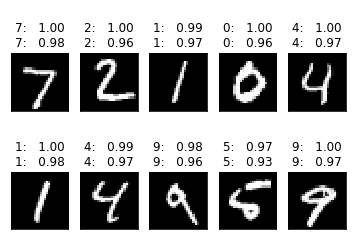

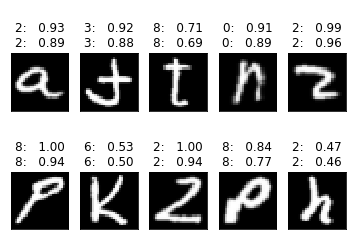

In [94]:
robust_model.log_pz_lam.data = torch.tensor(-5.).to(device)

data = enumerate(dl.test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)
    
data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)

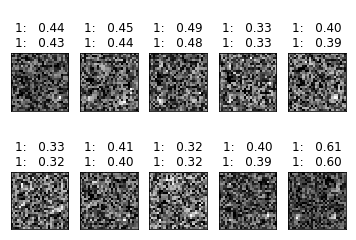

In [6]:
robust_model.eval()
perturbed_image = tt.generate_adv_noise(base_model, .9, device=device)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plotting.plot_samples([y_base, y], perturbed_image.detach().cpu())

In [103]:
import torch

lr = .0001
momentum = .9

#optimizer = optim.SGD([{"params":robust_model.gmm.parameters()}, {"params":robust_model.log_pz_lam}], lr=lr, momentum=momentum)

#optimizer = optim.SGD(robust_model.gmm.parameters(), lr=lr, momentum=momentum)
optimizer = optim.SGD([robust_model.gmm.alpha, robust_model.gmm.logvar], lr=lr, momentum=momentum)


for epoch in range(2):
    optimizer.param_groups[0]['lr'] *= .8
    tt.train_adv(robust_model, device, dl.train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.774529
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.372429
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.351294
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.374229
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.330523
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.340730
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.340102
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.323793
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.295429
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.326414
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.320783
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.303746


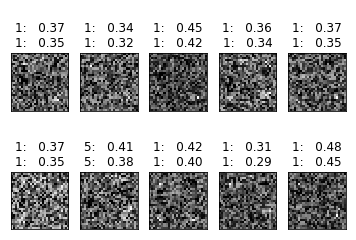

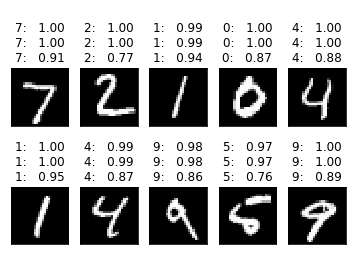

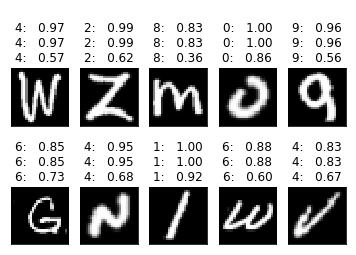

In [10]:


robust_model.eval()

perturbed_image = tt.generate_adv_noise(robust_model.base_model, 3., device=device)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plotting.plot_samples([y_base, y], perturbed_image.cpu())


data = enumerate(dl.test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y2 = robust_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y2 = robust_model.base_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y2, y], data)


In [11]:
tt.test(robust_model, device, dl.test_loader)
tt.test(robust_model_orig, device, dl.test_loader)
tt.test(base_model, device, dl.test_loader)


Test set: Average loss: 0.1916, Accuracy: 9824/10000 (98%), Ave. Confidence: 84%


Test set: Average loss: 0.2450, Accuracy: 9779/10000 (98%), Ave. Confidence: 80%


Test set: Average loss: 0.0426, Accuracy: 9848/10000 (98%), Ave. Confidence: 98%



(9848, 0.9777726332187653)

In [12]:
tt.test_adv(robust_model, device, dl.EMNIST_test_loader)
tt.test_adv(robust_model_orig, device, dl.EMNIST_test_loader)
tt.test_adv(base_model, device, dl.EMNIST_test_loader)


Ave. Confidence: 59%


Ave. Confidence: 56%


Ave. Confidence: 79%



0.7927921636058735

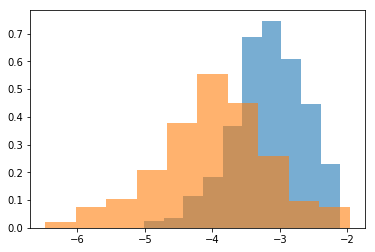

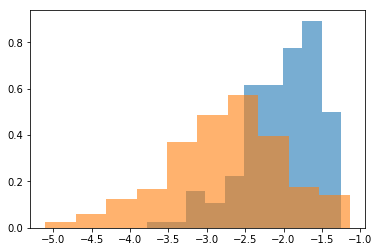

In [13]:
like = robust_model.gmm(dl.X_MNIST[0:300].to(device))
like_E = robust_model.gmm(dl.X_EMNIST[0:300].to(device))
plt.hist(torch.logsumexp(like,dim=0).detach().cpu(), density=True, alpha=.6)
plt.hist(torch.logsumexp(like_E,dim=0).detach().cpu(), density=True, alpha=.6)
plt.show()

like2 = robust_model_orig.gmm(dl.X_MNIST[0:300].to(device))
like_E2 = robust_model_orig.gmm(dl.X_EMNIST[0:300].to(device))
plt.hist(torch.logsumexp(like2,dim=0).detach().cpu(), density=True, alpha=.6)
plt.hist(torch.logsumexp(like_E2,dim=0).detach().cpu(), density=True, alpha=.6)
plt.show()

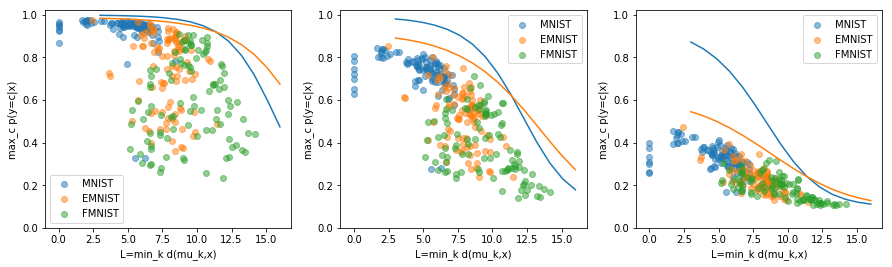

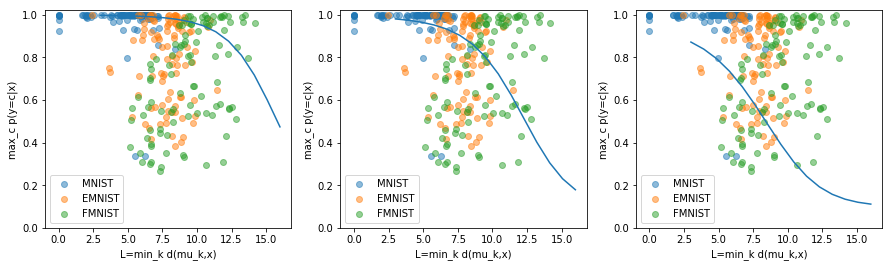

In [142]:
robust_model.log_pz_lam.data = torch.tensor(-8.,device=device)
plt.figure(figsize=(15,4))


def bound(L):
    xi = (robust_model.gmm.calculate_bound(L)-robust_model.log_pz_lam).exp()
    return .1*(1+10*xi)/(1+xi)

def bound2(L):
    var = robust_model.gmm.logvar.exp().max()
    epsilon = .4/var*torch.exp(-.5*L**2/var) / robust_model.log_pz_lam.exp()*(9*robust_model.gmm.alpha.sum())
    return .1*(1+10*epsilon)/(1+epsilon)


n = 1
data = []
for _ in range(n):
    data.append(enumerate(dl.train_loader).__next__()[1][0])
data_MNIST = torch.cat(data, dim=0)
Lm = (data_MNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]

data = []
for _ in range(n):
    data.append(enumerate(dl.EMNIST_train_loader).__next__()[1][0])
data_EMNIST = torch.cat(data, dim=0)
Le = (data_EMNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]

data = []
for _ in range(n):
    data.append(enumerate(dl.fashion_train_loader).__next__()[1][0])
data_FMNIST = torch.cat(data, dim=0)
Lf = (data_FMNIST.view(n*100,784)[:,None,:]-dl.X_MNIST[None,:,:]).norm(dim=2).min(dim=1)[0]


for i in range(3):
    plt.subplot(1,3,i+1)
    robust_model.log_pz_lam.data += 2.
    xv = np.linspace(3., 16.,15)
    plt.plot(xv, [bound(x) for x in xv] )
    plt.plot(xv, [bound2(x) for x in xv] )

    y = robust_model(data_MNIST.to(device)).max(dim=1)[0].exp()
    ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.5)

    y = robust_model(data_EMNIST.to(device)).max(dim=1)[0].exp()
    es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.5)
    
    y = robust_model(data_FMNIST.to(device)).max(dim=1)[0].exp()
    fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.5)

    plt.xlabel('L=min_k d(mu_k,x)')
    plt.ylabel('max_c p(y=c|x)')
    plt.legend(( ms, es, fs),
               ('MNIST', 'EMNIST', 'FMNIST'))
    plt.ylim([0,1.02])
plt.show()

robust_model.log_pz_lam.data = torch.tensor(-8.,device=device)
plt.figure(figsize=(15,4))

for i in range(3):
    plt.subplot(1,3,i+1)
    robust_model.log_pz_lam.data += 2.
    xv = np.linspace(3., 16.,15)
    plt.plot(xv, [bound(x) for x in xv] )

    y = robust_model.base_model(data_MNIST.to(device)).max(dim=1)[0].exp()
    ms = plt.scatter(Lm.detach(),y.detach().cpu().numpy(),alpha=.5)

    y = robust_model.base_model(data_EMNIST.to(device)).max(dim=1)[0].exp()
    es = plt.scatter(Le.detach(),y.detach().cpu().numpy(),alpha=.5)
    
    y = robust_model.base_model(data_FMNIST.to(device)).max(dim=1)[0].exp()
    fs = plt.scatter(Lf.detach(),y.detach().cpu().numpy(),alpha=.5)

    plt.xlabel('L=min_k d(mu_k,x)')
    plt.ylabel('max_c p(y=c|x)')
    plt.legend(( ms, es, fs),
               ('MNIST', 'EMNIST', 'FMNIST'))
    plt.ylim([0,1.02])
plt.show()



In [97]:
L_k = (dl.X_MNIST[:,None,:]-robust_model.gmm.mu.data.cpu()[None,:,:]).norm(dim=2).min(dim=0)[0]

In [87]:
L_k.max()

tensor(8.7545)

In [124]:
xi = 3*robust_model.gmm.alpha.max()/np.exp(-8.)

In [125]:
.1*(1+10*xi)/(1+xi)

tensor(0.9889, device='cuda:0', grad_fn=<DivBackward0>)